In [1]:
%load_ext autoreload
%autoreload 2
import os
import glob
import random
import cv2
import pandas as pd
import numpy as np
import mrcnn.model as modellib
from mrcnn.model import log
from mrcnn import utils
from mrcnn import visualize
from config import BUS_DS_Config
from dataset import BUS_Dataset
from matplotlib import pyplot as plt

Using TensorFlow backend.


In [2]:
# Display Model Configuration
config = BUS_DS_Config()
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     16
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        1
DETECTION_MIN_CONFIDENCE       0.8
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 16
IMAGE_CHANNEL_COUNT            1
IMAGE_MAX_DIM                  128
IMAGE_META_SIZE                15
IMAGE_MIN_DIM                  128
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [128 128   1]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE             

In [3]:
# Directory to save logs and trained model
# Root directory of the project
ROOT_DIR = 'models/mask_rcnn_seg_models'
MODEL_DIR = os.path.join(ROOT_DIR, 'trained_models')

class InferenceConfig(BUS_DS_Config):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

inference_config = InferenceConfig()

# Recreate the model in inference mode
model = modellib.MaskRCNN(mode="inference", 
                          config=inference_config,
                          model_dir=MODEL_DIR)

# Get path to saved weights
# Either set a specific path or find last trained weights

model_path = model.find_last()
# # Load trained weights
print("Loading weights from ", model_path)
model.load_weights(model_path, by_name=True)
# model.load_weights('models/mask_rcnn_seg_models/trained_models/instance-seg-lesion-dice_loss-no-normals20200220T1952/mask_rcnn_instance-seg-lesion-dice_loss-no-normals_0010.h5', by_name=True)


Loading weights from  /external_drive/BUS_Deep_Learning/models/mask_rcnn_seg_models/trained_models/instance-seg-lesion-bce_loss-with-normals-class_bm-cocotl20200221T2104/mask_rcnn_instance-seg-lesion-bce_loss-with-normals-class_bm-cocotl_0010.h5
Re-starting from epoch 10


In [4]:
model.keras_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_image (InputLayer)        (None, 128, 128, 1)  0                                            
__________________________________________________________________________________________________
zero_padding2d_1 (ZeroPadding2D (None, 134, 134, 1)  0           input_image[0][0]                
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 64, 64, 64)   3200        zero_padding2d_1[0][0]           
__________________________________________________________________________________________________
bn_conv1 (BatchNorm)            (None, 64, 64, 64)   256         conv1[0][0]                      
__________________________________________________________________________________________________
activation

In [5]:
# class_names = np.array(['lesion'])
class_names = np.array(['benign','malignant'])

In [6]:
path_to_train_set = 'data/seg_dir_instance_seg/train_images'
path_to_val_set = 'data/seg_dir_instance_seg/val_images'
# Training dataset
dataset_train = BUS_Dataset()
dataset_train.load_data(class_names, path_to_train_set)
dataset_train.prepare()
# Validation dataset
dataset_val = BUS_Dataset()
dataset_val.load_data(class_names, path_to_val_set)
dataset_val.prepare()

In [7]:
def get_ax(rows=1, cols=1, size=8):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Change the default size attribute to control the size
    of rendered images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

original_image           shape: (128, 128, 1)         min:    0.00000  max:  255.00000  uint8
image_meta               shape: (15,)                 min:    0.00000  max:  562.00000  float64
gt_class_id              shape: (1,)                  min:    1.00000  max:    1.00000  int64
gt_bbox                  shape: (1, 4)                min:   23.00000  max:   56.00000  int32
gt_mask                  shape: (128, 128, 1)         min:    0.00000  max:  255.00000  uint8


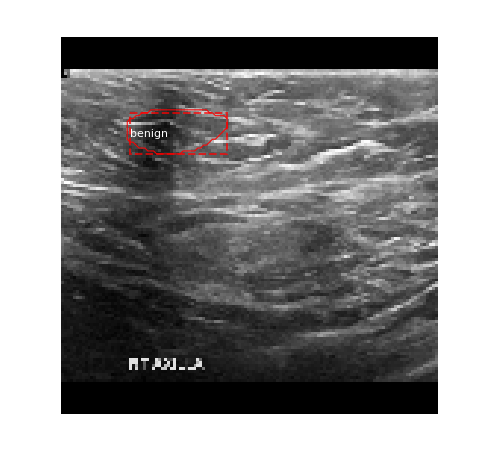

In [8]:
# Test on a random image
image_id = random.choice(dataset_val.image_ids)
original_image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(dataset_val, inference_config, 
                           image_id, use_mini_mask=False)

log("original_image", original_image)
log("image_meta", image_meta)
log("gt_class_id", gt_class_id)
log("gt_bbox", gt_bbox)
log("gt_mask", gt_mask)

image_for_disp = np.squeeze(original_image, axis=2)
image_for_disp = cv2.cvtColor(image_for_disp,cv2.COLOR_GRAY2RGB)

visualize.display_instances(image_for_disp, gt_bbox, gt_mask, gt_class_id, 
                            dataset_val.class_names, figsize=(8, 8))

Processing 1 images
image                    shape: (128, 128, 1)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 128, 128, 1)      min: -117.00000  max:  138.00000  float64
image_metas              shape: (1, 15)               min:    0.00000  max:  128.00000  int64
anchors                  shape: (1, 4092, 4)          min:   -0.71267  max:    1.20874  float32


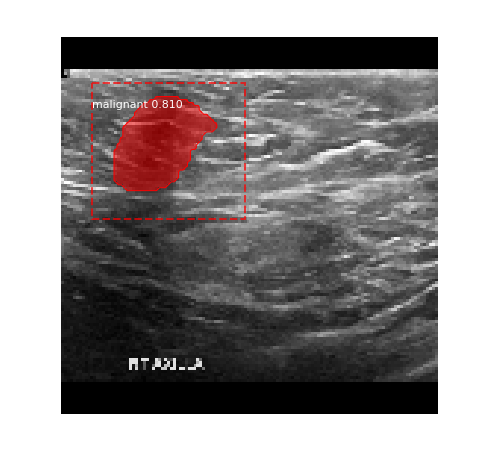

In [9]:
results = model.detect([original_image], verbose=1)

r = results[0]
visualize.display_instances(image_for_disp, r['rois'], r['masks'], r['class_ids'], 
                            dataset_val.class_names, r['scores'], ax=get_ax())

In [10]:
def merge_masks(arr):
    if np.any(arr!=0):
        return 1
    else:
        return 0 

In [17]:
#Benign/Malignant
image_ids = dataset_val.image_ids
class_pred = []
class_gt = []
for image_id in image_ids:
    print('image id : ', image_id)
    # Load image and ground truth data
    image, image_meta, gt_class_id, gt_bbox, gt_mask =\
        modellib.load_image_gt(dataset_val, inference_config,
                               image_id, use_mini_mask=False)
    molded_images = np.expand_dims(modellib.mold_image(image, inference_config), 0)
    # Run object detection
    results = model.detect([image], verbose=0)
    r = results[0]
    print(dataset_val.image_info[image_id]['path'])
    
    if len(gt_class_id)==0:
        class_gt.append('normal')
    if 1 in gt_class_id:
        class_gt.append('benign')
    if 2 in gt_class_id:
        class_gt.append('malignant')
        
    if len(r['class_ids'])==0:
        class_pred.append('normal')
    if 1 in r['class_ids']:
        class_pred.append('benign')
    if 2 in r['class_ids']:
        class_pred.append('malignant')  

image id :  0
data/seg_dir_instance_seg/val_images/malignant (66).png
image id :  1
data/seg_dir_instance_seg/val_images/benign (154).png
image id :  2
data/seg_dir_instance_seg/val_images/benign (391).png
image id :  3
data/seg_dir_instance_seg/val_images/benign (167).png
image id :  4
data/seg_dir_instance_seg/val_images/benign (227).png
image id :  5
data/seg_dir_instance_seg/val_images/normal (84).png
image id :  6
data/seg_dir_instance_seg/val_images/benign (51).png
image id :  7
data/seg_dir_instance_seg/val_images/benign (400).png
image id :  8
data/seg_dir_instance_seg/val_images/normal (33).png
image id :  9
data/seg_dir_instance_seg/val_images/benign (123).png
image id :  10
data/seg_dir_instance_seg/val_images/malignant (86).png
image id :  11
data/seg_dir_instance_seg/val_images/normal (113).png
image id :  12
data/seg_dir_instance_seg/val_images/benign (204).png
image id :  13
data/seg_dir_instance_seg/val_images/benign (356).png
image id :  14
data/seg_dir_instance_seg/va

data/seg_dir_instance_seg/val_images/malignant (58).png
image id :  120
data/seg_dir_instance_seg/val_images/malignant (201).png
image id :  121
data/seg_dir_instance_seg/val_images/normal (82).png
image id :  122
data/seg_dir_instance_seg/val_images/normal (109).png
image id :  123
data/seg_dir_instance_seg/val_images/benign (80).png
image id :  124
data/seg_dir_instance_seg/val_images/benign (33).png
image id :  125
data/seg_dir_instance_seg/val_images/malignant (180).png
image id :  126
data/seg_dir_instance_seg/val_images/benign (153).png
image id :  127
data/seg_dir_instance_seg/val_images/benign (225).png
image id :  128
data/seg_dir_instance_seg/val_images/malignant (53).png
image id :  129
data/seg_dir_instance_seg/val_images/benign (94).png
image id :  130
data/seg_dir_instance_seg/val_images/benign (274).png
image id :  131
data/seg_dir_instance_seg/val_images/malignant (96).png
image id :  132
data/seg_dir_instance_seg/val_images/malignant (27).png
image id :  133
data/seg_d

In [18]:
comparison_benign_malignant = pd.DataFrame(columns = ['gt', 'pred'])
comparison_benign_malignant['gt'] = class_gt
comparison_benign_malignant['pred'] = class_pred

In [19]:
comparison_benign_malignant.head()

,gt,pred
0,malignant,normal
1,benign,benign
2,benign,normal
3,benign,benign
4,benign,normal


In [20]:
#overall
len(comparison_benign_malignant.loc[comparison_benign_malignant['gt']==comparison_benign_malignant['pred']])/len(comparison_benign_malignant)

0.48717948717948717

In [21]:
#benign
benign = comparison_benign_malignant.loc[comparison_benign_malignant['gt']=='benign']

In [22]:
len(benign.loc[benign['pred']=='benign'])/len(benign)

0.3793103448275862

In [23]:
#malignant
malignant = comparison_benign_malignant.loc[comparison_benign_malignant['gt']=='malignant']

In [24]:
len(malignant.loc[malignant['pred']=='malignant'])/len(malignant)

0.6428571428571429

In [25]:
#normal
normal = comparison_benign_malignant.loc[comparison_benign_malignant['gt']=='normal']

In [26]:
len(normal.loc[normal['pred']=='normal'])/len(normal)

0.5925925925925926

In [ ]:
#Segmentation Metrics
smooth = 1 

image_ids = dataset_val.image_ids
IOU = []
Dice = []
for image_id in image_ids:
    print('image id : ', image_id)
    # Load image and ground truth data
    image, image_meta, gt_class_id, gt_bbox, gt_mask =\
        modellib.load_image_gt(dataset_val, inference_config,
                               image_id, use_mini_mask=False)
    molded_images = np.expand_dims(modellib.mold_image(image, inference_config), 0)
    # Run object detection
    results = model.detect([image], verbose=0)
    r = results[0]
    if r['masks'].shape[2]==0:
        mask = np.zeros((128,128)).astype(np.uint8)  
    else:
        mask = r['masks'][:, :, 0].astype(np.uint8)
    gt_mask = np.apply_along_axis(merge_masks, 2, gt_mask).astype(np.uint8)
    print(np.unique(gt_mask,return_counts=True))
# #     If no ground truth mask define mask of zeroes
#     if gt_mask.shape[2]==0:
#         gt_mask = np.zeros((128,128)).astype(np.uint8)  
#     elif gt_mask.shape[2]==1:      
#         gt_mask = np.squeeze(gt_mask).astype(np.uint8)   
#     else:
#         gt_mask = np.apply_along_axis(merge_masks, 2, gt_mask).astype(np.uint8)            
    tp = np.sum(mask.flatten()*gt_mask.flatten())
    fp = np.sum((1-mask.flatten())*gt_mask.flatten())
    fn = np.sum(mask.flatten()*(1-gt_mask.flatten()))
    tn = np.sum((1-mask.flatten())*(1-gt_mask.flatten()))
    iou = (tp+smooth)/(tp+fp+fn+smooth)
    dice_loss = (2*tp+smooth)/((2*tp)+fp+fn+smooth)
    IOU.append(iou)
    Dice.append(dice_loss)
    print('iou --> ',iou)
    print('dice loss--> ',dice_loss)
#     # Compute AP
#     AP, precisions, recalls, overlaps =\
#         utils.compute_ap(gt_bbox, gt_class_id, gt_mask,
#                          r["rois"], r["class_ids"], r["scores"], r['masks'])
#     APs.append(AP)
    
# print("mAP: ", np.mean(APs))